# Machine Learning Exploration of Factors Affecting Student Retention

## Importing Necessary Modules

In [ ]:
import numpy as np  # Handling arrays
import pandas as pd  # Data manipulation and handling
import seaborn as sns  # Charting and visualisation
import matplotlib.pyplot as plt  # Further charting functionality
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
from sklearn.preprocessing import RobustScaler  # Scaling data with outliers
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedKFold,
    cross_val_score,
    cross_val_predict,
)  # Cross evaluation
from sklearn.svm import SVC  # Support vector classifier model
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
)  # Logistic & linear regression models
from sklearn.cluster import KMeans  # K-means Clustering model
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)  # Model scoring
from imblearn.pipeline import Pipeline  # Creating preprocessing pipelines
from imblearn.over_sampling import SMOTE  # Handling imbalanced data

## Data Retrieval

Imported the student retention dataset as a Pandas DataFrame.

In [ ]:
stud_ret_df = pd.read_csv("/work/StudentRetentionMlData.csv")
stud_ret_df.head()

,AnonymisedEnrolmentID,CourseDeliveryMethodID,AnonymisedSiteID,OverallPossibleAttendance,OverallAttendance,ConcernCommentsCount,CompletionStatusID,CompletionStatusDesc
0,8,1,1,315,297,4.0,2,Completed
1,16,1,1,322,255,6.0,2,Completed
2,24,1,1,295,224,NaN,2,Completed
3,32,1,1,320,217,5.0,2,Completed
4,40,1,1,264,254,1.0,2,Completed


Added an 'OverallAttendancePercent' column by dividing 'OverallAttendance' by 'OverallPossibleAttendance'. 

In [ ]:
stud_ret_df["OverallAttendancePercent"] = stud_ret_df.apply(
    lambda row: row["OverallAttendance"] / row["OverallPossibleAttendance"]
    if row["OverallPossibleAttendance"] > 0  # Avoid divide by 0
    else 0,  # Set to 0 if unable to calculate attendance%
    axis=1,
)

stud_ret_df["OverallAttendancePercent"] = (
    stud_ret_df["OverallAttendancePercent"] * 100
)  # Better readibility

## Data Cleansing

Checked the shape of 'stud_ret_df', this correctly matches 'StudentRetentionMlData.csv'

In [ ]:
stud_ret_df.shape

(12044, 9)

Printed stud_ret_df DataFrame information, the following issues were identified:
* 'ConcernCommentsCount' had missing values.
* 'ConcernCommentsCount' was data type float, this was expected to be integer.
* 'CompletionStatusID' was data type object, this was expected to be integer.

In [ ]:
stud_ret_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12044 entries, 0 to 12043
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AnonymisedEnrolmentID      12044 non-null  int64  
 1   CourseDeliveryMethodID     12044 non-null  int64  
 2   AnonymisedSiteID           12044 non-null  int64  
 3   OverallPossibleAttendance  12044 non-null  int64  
 4   OverallAttendance          12044 non-null  int64  
 5   ConcernCommentsCount       9928 non-null   float64
 6   CompletionStatusID         12044 non-null  object 
 7   CompletionStatusDesc       12044 non-null  object 
 8   OverallAttendancePercent   12044 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 847.0+ KB


Highlighted the missing values, 2116 were present in 'ConcernCommentsCount'.

In [ ]:
stud_ret_df.isna().sum()

AnonymisedEnrolmentID           0
CourseDeliveryMethodID          0
AnonymisedSiteID                0
OverallPossibleAttendance       0
OverallAttendance               0
ConcernCommentsCount         2116
CompletionStatusID              0
CompletionStatusDesc            0
OverallAttendancePercent        0
dtype: int64

Missing values in 'ConcernCommentsCount' were replaced with zeroes and the column converted to data type integer.

In [ ]:
stud_ret_df["ConcernCommentsCount"] = (
    stud_ret_df["ConcernCommentsCount"].fillna(0).astype(int)
)
stud_ret_df.isna().sum() # Double-checking for duplicates

AnonymisedEnrolmentID        0
CourseDeliveryMethodID       0
AnonymisedSiteID             0
OverallPossibleAttendance    0
OverallAttendance            0
ConcernCommentsCount         0
CompletionStatusID           0
CompletionStatusDesc         0
OverallAttendancePercent     0
dtype: int64

Counted the unique values of 'CourseDeliveryMethodID', there were only two delivery method types and it almost entirely consists of 'CourseDeliveryMethodID' = 1

In [ ]:
stud_ret_df["CourseDeliveryMethodID"].value_counts()

CourseDeliveryMethodID
1    12005
7       39
Name: count, dtype: int64

This column was deemed not useful for analysis or machine learning, so 'CourseDeliveryMethodID' was dropped.

In [ ]:
stud_ret_df = stud_ret_df.drop(columns=["CourseDeliveryMethodID"])

Counted the unique values of 'CompletionStatusID' and 'CompletionStatusDesc'

In [ ]:
stud_ret_df[["CompletionStatusID","CompletionStatusDesc"]].value_counts()

CompletionStatusID  CompletionStatusDesc 
2                   Completed                9566
3                   Withdrawn                2462
X                   Cancelled                  14
6                   Temporarily withdrawn       2
Name: count, dtype: int64

Since the dataset primarily consists of 'Completed' statuses, the remaining statuses, all of which indicate that a student did not complete their course, were combined into a single category. This allowed the 'CompletionStatusID' column to be converted to an integer data type, as the 'CompletionStatusID' = "X" values were no longer present.

In [ ]:
stud_ret_df["CompletionStatusID"] = (
    stud_ret_df["CompletionStatusID"]
    .replace(to_replace=["3", "X", "6"], value=1)
    .astype(int)
)
stud_ret_df["CompletionStatusDesc"] = stud_ret_df["CompletionStatusDesc"].replace(
    to_replace=["Withdrawn", "Cancelled", "Temporarily withdrawn"], value="Uncompleted"
)

stud_ret_df[["CompletionStatusID", "CompletionStatusDesc"]].value_counts()

CompletionStatusID  CompletionStatusDesc
2                   Completed               9566
1                   Uncompleted             2478
Name: count, dtype: int64

Counted the unique values of 'AnonymisedSiteID'.

In [ ]:
stud_ret_df["AnonymisedSiteID"].value_counts()

AnonymisedSiteID
2    7909
1    4096
3      39
Name: count, dtype: int64

There is not enough data for 'AnonymisedSiteID' = 3, so these were excluded

In [ ]:
stud_ret_df = stud_ret_df[stud_ret_df["AnonymisedSiteID"] != 3]

Checked for duplicate rows. None exist, so no action required.

In [ ]:
stud_ret_df.duplicated().sum()

0

Renamed the columns to provide cleaner visualisation.

In [ ]:
cols_rename_dict = {
    "AnonymisedEnrolmentID": "Anonymised ID",
    "AnonymisedSiteID": "Anonymised Site ID",
    "OverallPossibleAttendance": "Possible Attendance Marks",
    "OverallAttendance": "Actual Attendance Marks",
    "ConcernCommentsCount": "Comments of Concern",
    "CompletionStatusID": "Completion Status ID",
    "CompletionStatusDesc": "Completion Status Description",
    "OverallAttendancePercent": "Attendance%"
}

stud_ret_df = stud_ret_df.rename(columns=cols_rename_dict)

## Exploratory Data Analysis (EDA)

Printed statistics for 'stud_ret_df'

In [ ]:
stud_ret_df.describe()

,Anonymised ID,Anonymised Site ID,Possible Attendance Marks,Actual Attendance Marks,Comments of Concern,Completion Status ID,Attendance%
count,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000
mean,6003.683465,1.658809,225.630321,179.198584,7.595835,1.794169,74.782717
std,3466.854687,0.474129,102.133277,94.761494,9.737332,0.404324,22.561886
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3002.000000,1.000000,177.000000,108.000000,1.000000,2.000000,64.516129
50%,6003.000000,2.000000,257.000000,200.000000,4.000000,2.000000,81.250000
75%,9004.000000,2.000000,296.000000,252.000000,10.000000,2.000000,91.449814
max,12044.000000,2.000000,485.000000,473.000000,90.000000,2.000000,133.333333


This revealed cases of learners with no possible attendance, or having over 100% attendance. These were considered erroneus and removed.

In [ ]:
stud_ret_df = stud_ret_df[stud_ret_df["Possible Attendance Marks"] != 0]
stud_ret_df = stud_ret_df[stud_ret_df["Attendance%"] <= 100]

Reprinted the 'stud_ret_df' statistics after cleaning the attendance data.

In [ ]:
stud_ret_df.describe()

,Anonymised ID,Anonymised Site ID,Possible Attendance Marks,Actual Attendance Marks,Comments of Concern,Completion Status ID,Attendance%
count,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000
mean,6022.328174,1.658900,229.641636,182.190152,7.714857,1.807637,76.057073
std,3466.651969,0.474099,98.434966,92.400615,9.793014,0.394174,20.331831
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,3024.500000,1.000000,185.000000,116.000000,1.000000,2.000000,65.858556
50%,6029.000000,2.000000,258.000000,202.000000,4.000000,2.000000,81.639344
75%,9027.500000,2.000000,297.000000,253.000000,11.000000,2.000000,91.543203
max,12044.000000,2.000000,485.000000,473.000000,90.000000,2.000000,100.000000


Created correlation heatmap between 'Attendance%' and 'Comments of Concern'.

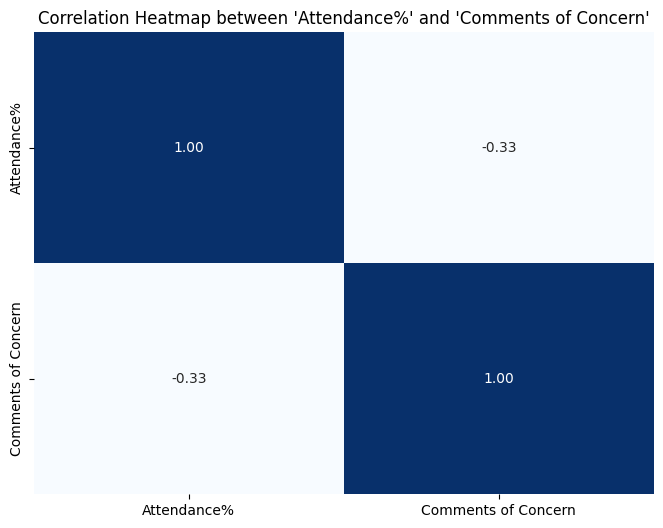

In [ ]:
# Create correlation matrix
corr_matrix = stud_ret_df[["Attendance%", "Comments of Concern"]].corr()

# Generate heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Correlation Heatmap between 'Attendance%' and 'Comments of Concern'")

# Display plot
plt.show()

Box plots were created to examine the distribution of the numeric attributes.

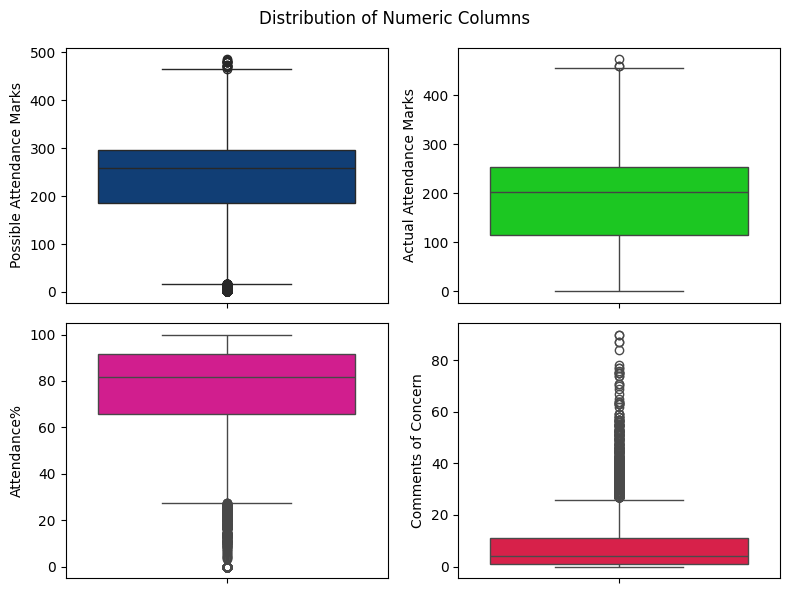

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Generate boxplots
sns.boxplot(stud_ret_df["Possible Attendance Marks"], ax=axs[0, 0], color="#003C86")
sns.boxplot(stud_ret_df["Actual Attendance Marks"], ax=axs[0, 1], color="#00E307")
sns.boxplot(stud_ret_df["Attendance%"], ax=axs[1, 0], color="#EF0096")
sns.boxplot(stud_ret_df["Comments of Concern"], ax=axs[1, 1], color="#F60239")

# Create super chart title
plt.suptitle("Distribution of Numeric Columns")

# Display plots
plt.tight_layout()
plt.show()

Pair plots were generated to compare 'Attendance%' with 'Comments of Concern', by 'Completion Status Description'.

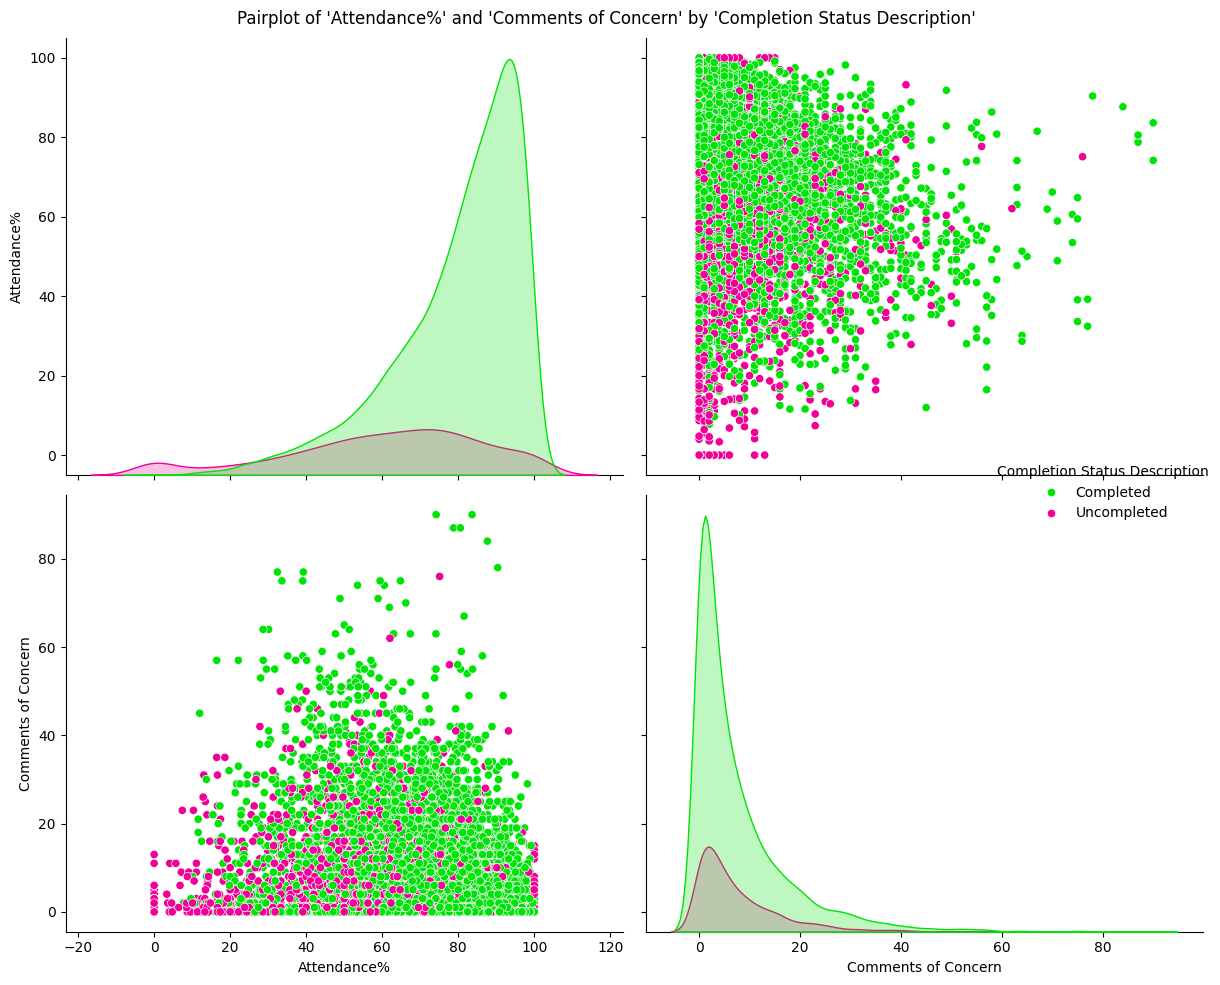

In [ ]:
# Create custom colour pallete
status_palette = {"Completed": "#00E307", "Uncompleted": "#EF0096"}

# Generate pair plot
sns.pairplot(
    data=stud_ret_df[
        ["Attendance%", "Comments of Concern", "Completion Status Description"]
    ],
    hue="Completion Status Description",
    palette=status_palette,
    height=5,
    aspect=1,
)

# Create super chart title
plt.suptitle(
    "Pairplot of 'Attendance%' and 'Comments of Concern' by 'Completion Status Description'"
)

# Display plots
plt.tight_layout()
plt.show()

Pair plots were generated to compare 'Attendance%' with 'Comments of Concern', by 'Anonymised Site ID'.

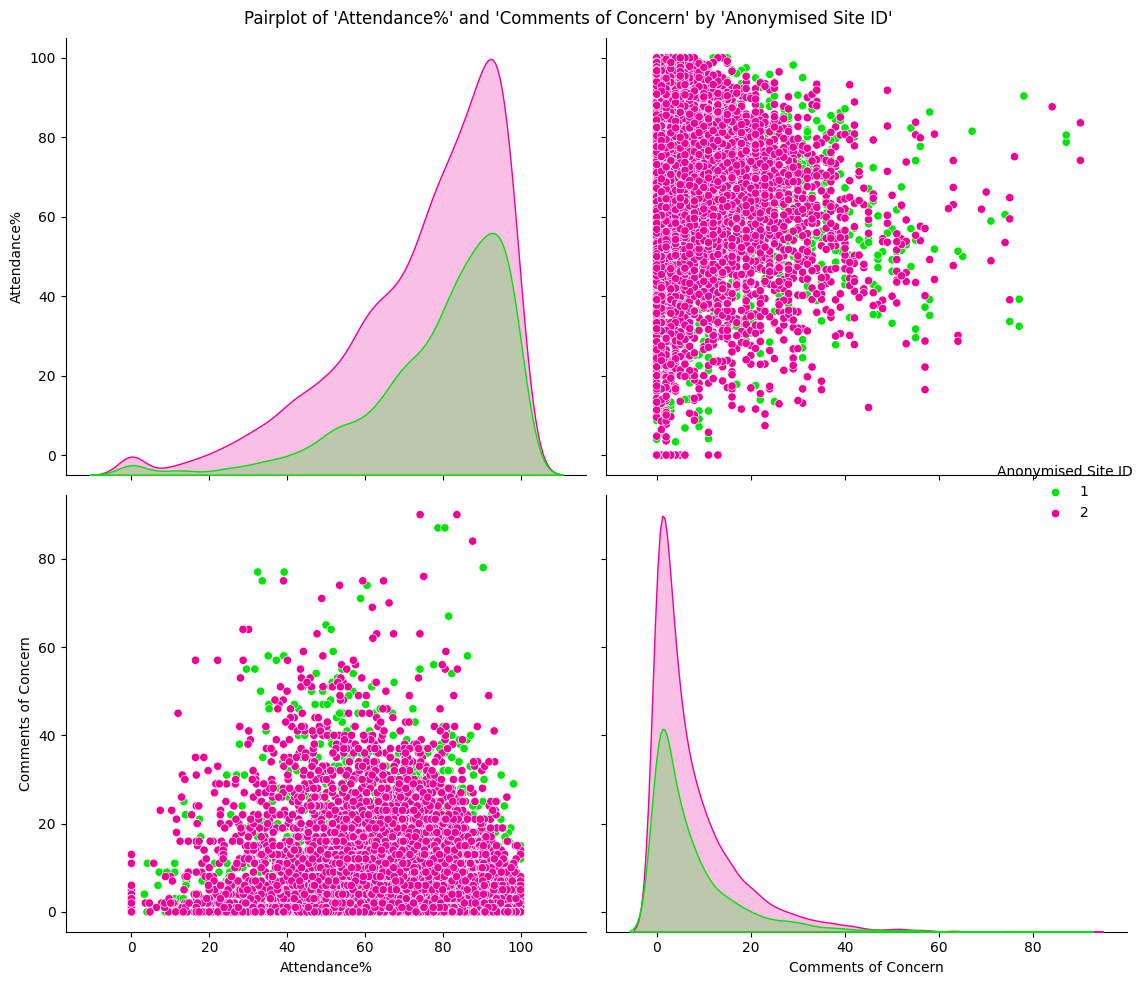

In [ ]:
# Create custom colour pallette
site_palette = {1: "#00E307", 2: "#EF0096"}

# Generate pair plot
sns.pairplot(
    data=stud_ret_df[["Attendance%", "Comments of Concern", "Anonymised Site ID"]],
    hue="Anonymised Site ID",
    palette=site_palette,
    height=5,
    aspect=1,
)

# Create super chat title
plt.suptitle(
    "Pairplot of 'Attendance%' and 'Comments of Concern' by 'Anonymised Site ID'"
)

# Display plots
plt.tight_layout()
plt.show()

Histograms were created to analyse the distribution of 'Attendance%' by 'Completion Status Description'.

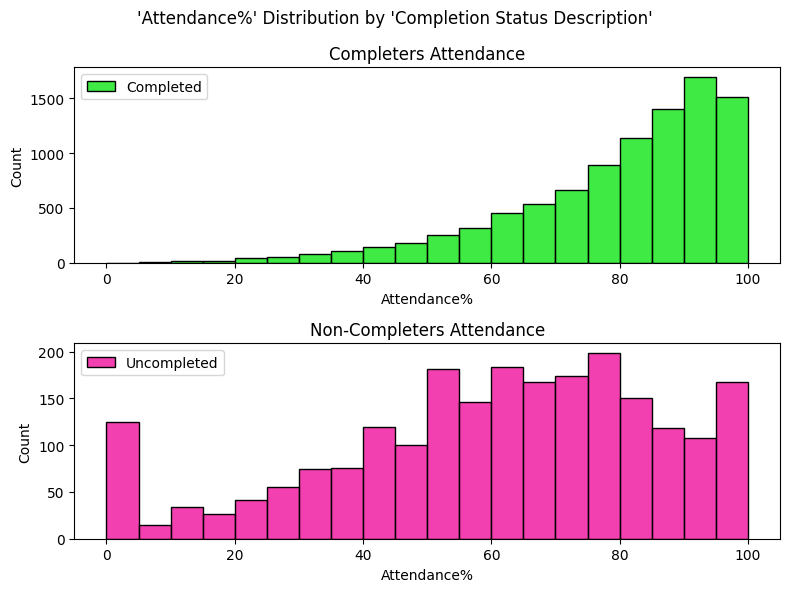

In [ ]:
# Filter data for completers and non-completers
completers = stud_ret_df[stud_ret_df["Completion Status Description"] == "Completed"]
non_completers = stud_ret_df[
    stud_ret_df["Completion Status Description"] == "Uncompleted"
]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Generate histograms with same bins
sns.histplot(
    data=completers["Attendance%"],
    bins=20,
    ax=axs[0],
    color="#00E307",
    label="Completed",
)
sns.histplot(
    data=non_completers["Attendance%"],
    bins=20,
    ax=axs[1],
    color="#EF0096",
    label="Uncompleted",
)

# Create chart titles
axs[0].set_title("Completers Attendance")
axs[1].set_title("Non-Completers Attendance")

# Add legends
axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")

# Create super chart title
plt.suptitle("'Attendance%' Distribution by 'Completion Status Description'")

# Display plots
plt.tight_layout()
plt.show()

Histograms were created to closely analyse the distribution of 'Attendance%' by 'Anonymised Site ID'.

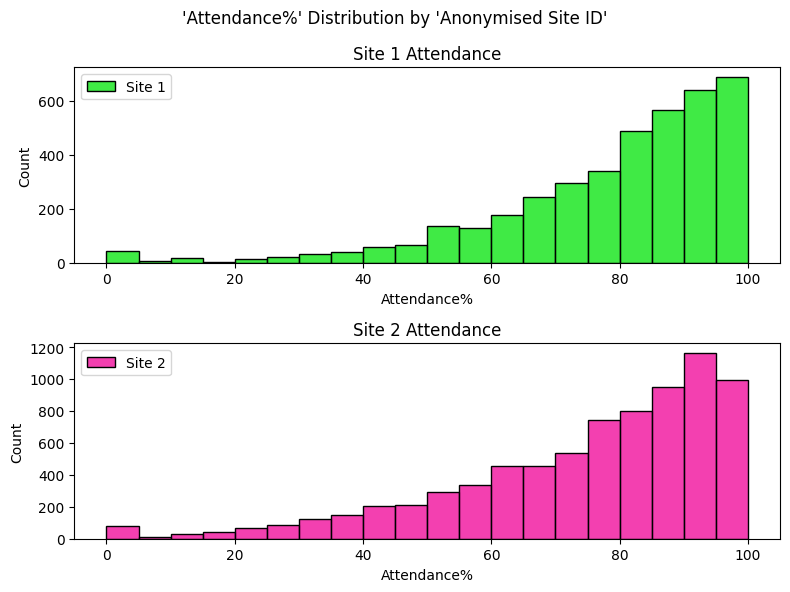

In [ ]:
# Filter data for completers and non-completers
site_1 = stud_ret_df[stud_ret_df["Anonymised Site ID"] == 1]
site_2 = stud_ret_df[stud_ret_df["Anonymised Site ID"] == 2]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Generate histograms with same bins
sns.histplot(
    data=site_1["Attendance%"], bins=20, ax=axs[0], color="#00E307", label="Site 1"
)
sns.histplot(
    data=site_2["Attendance%"], bins=20, ax=axs[1], color="#EF0096", label="Site 2"
)

# Create chart titles
axs[0].set_title("Site 1 Attendance")
axs[1].set_title("Site 2 Attendance")

# Add legends
axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")

# Create super chart title
plt.suptitle("'Attendance%' Distribution by 'Anonymised Site ID'")

# Display plots
plt.tight_layout()
plt.show()

Histograms were created to closely analyse the distribution of 'Comments of Concern' by 'Completion Status Description'.

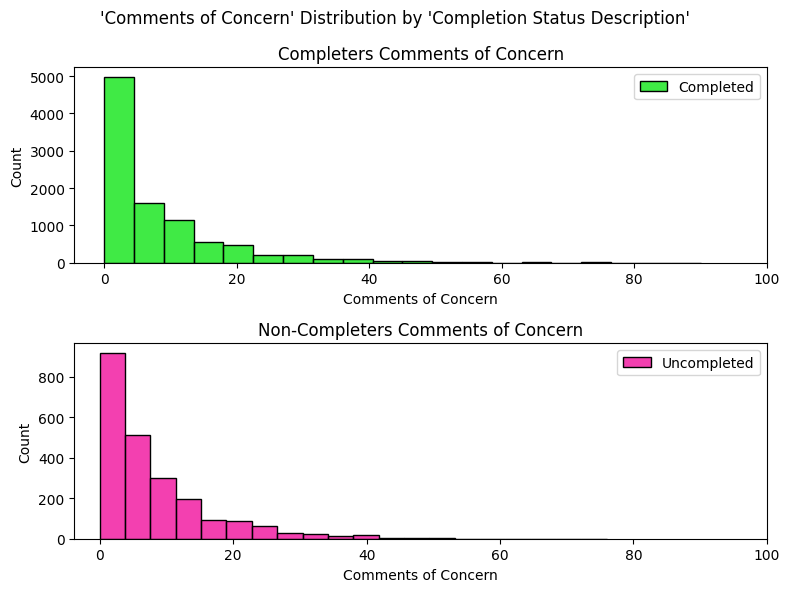

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Generate histograms with same bins
sns.histplot(
    data=completers["Comments of Concern"],
    bins=20,
    ax=axs[0],
    color="#00E307",
    label="Completed",
)
sns.histplot(
    data=non_completers["Comments of Concern"],
    bins=20,
    ax=axs[1],
    color="#EF0096",
    label="Uncompleted",
)

# Set x-ticks
axs[0].set_xticks(range(0, 101, 20))
axs[1].set_xticks(range(0, 101, 20))

# Create chart titles
axs[0].set_title("Completers Comments of Concern")
axs[1].set_title("Non-Completers Comments of Concern")

# Add legends
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")

# Create super chart title
plt.suptitle("'Comments of Concern' Distribution by 'Completion Status Description'")

# Display plots
plt.tight_layout()
plt.show()

Histograms were created to closely analyse the distribution of 'Comments of Concern' by 'Anonymised Site ID'.

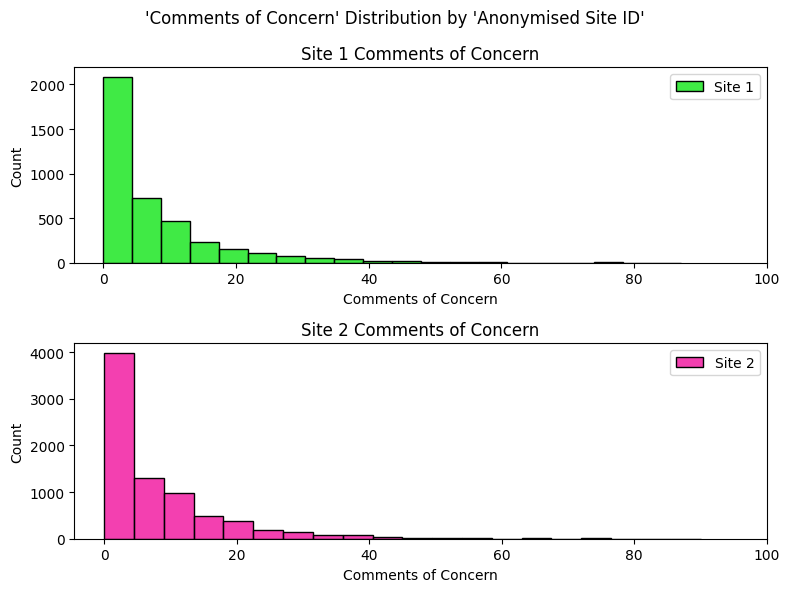

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Generate histograms with same bins
sns.histplot(
    data=site_1["Comments of Concern"],
    bins=20,
    ax=axs[0],
    color="#00E307",
    label="Site 1",
)
sns.histplot(
    data=site_2["Comments of Concern"],
    bins=20,
    ax=axs[1],
    color="#EF0096",
    label="Site 2",
)

# Set x-ticks
axs[0].set_xticks(range(0, 101, 20))
axs[1].set_xticks(range(0, 101, 20))

# Create chart titles
axs[0].set_title("Site 1 Comments of Concern")
axs[1].set_title("Site 2 Comments of Concern")

# Add legends
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")

# Create super chart title
plt.suptitle("'Comments of Concern' Distribution by 'Anonymised Site ID'")

# Display plots
plt.tight_layout()
plt.show()

## Constructing Machine Learning Models

### Predicting Students' Completion Statuses

To begin the modelling process, the features and target attributes were split into X and y respectively.

In [ ]:
# Set X and y features and target variables respectively
X = stud_ret_df[['Anonymised Site ID', 'Attendance%', 'Comments of Concern']]
y = stud_ret_df['Completion Status ID']

#### Suport Vector Classification

Support Vector Classification (SVC) was used to predict students' completion statuses. This first model was intended to evaluate the model's behaviour with the dataset and identify issues.

Cross-validation results:  [0.82270408 0.82993197 0.82227891 0.8252551  0.82135262]
Mean cross-validation result:  0.8243045367870672

Classification report:
               precision    recall  f1-score   support

           1       0.78      0.12      0.21      2262
           2       0.83      0.99      0.90      9497

    accuracy                           0.82     11759
   macro avg       0.80      0.56      0.56     11759
weighted avg       0.82      0.82      0.77     11759



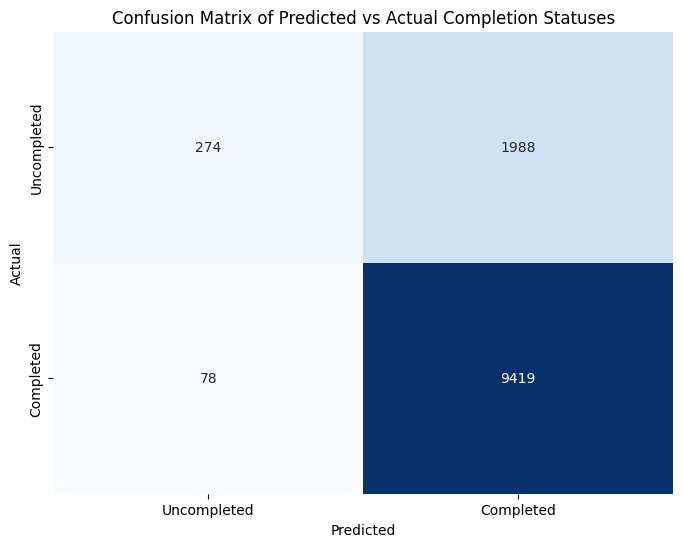

In [ ]:
# Initialise testing SVC model
svc_test = SVC(kernel="rbf", random_state=0)

# Set up stratified k-fold cross-validation
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Perform cross-validation
results = cross_val_score(svc_test, X, y, cv=strat_k_fold)

# Print the cross-validation scores
print("Cross-validation results: ", results)
print("Mean cross-validation result: ", results.mean())

# Predict labels using cross-validation
y_pred = cross_val_predict(svc_test, X, y, cv=strat_k_fold)

# Classification Report
print("\nClassification report:\n", classification_report(y, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

# Generate confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, cmap="Blues",annot=True, fmt="n",cbar=False)

# Set x-ticks
plt.xticks(ticks=[0.5, 1.5], labels=['Uncompleted', 'Completed'])
plt.yticks(ticks=[0.5, 1.5], labels=['Uncompleted', 'Completed'])

# Label axes
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Create chart title
plt.title("Confusion Matrix of Predicted vs Actual Completion Statuses")

# Display plot
plt.show()

The data was split into training and testing sets for subsequent modelling. To account for expected outliers in the data, the features were scaled using RobustScaler.

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scaling the features
scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[["Attendance%", "Comments of Concern"]] = scaler.fit_transform(
    X_train[["Attendance%", "Comments of Concern"]]
)
X_test_scaled[["Attendance%", "Comments of Concern"]] = scaler.transform(
    X_test[["Attendance%", "Comments of Concern"]]
)

Turned the classification model evaluation into functions to enhance efficiency.

In [ ]:
def model_eval_report(pipeline, X_train, y_train, X_test, y_test):
    """
    Evaluates classification models, prints the cross-validation results and
    returns a confusion matrix.
    """
    # Set up k-fold cross-validation
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Perform cross-validation
    results = cross_val_score(pipeline, X_train, y_train, cv=strat_k_fold)
    # Print the cross-validation scores
    print("Cross-validation results: ", results)
    print("Mean cross-validation result: ", results.mean())

    # Fit the pipeline for the training data
    pipeline.fit(X_train, y_train)

    # Predict labels using the pipeline for the test data
    y_pred = pipeline.predict(X_test)

    # Classification Report
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    return conf_matrix

def conf_mtx_heatmap(conf_matrix):
    """
    Generates a heatmap from an inputted confusion matrix.
    """
    # Generate confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, cmap="Blues",annot=True, fmt="n",cbar=False)

    # Set x-ticks
    plt.xticks(ticks=[0.5, 1.5], labels=['Uncompleted', 'Completed'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Uncompleted', 'Completed'])

    # Label axes
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Create chart title
    plt.title("Confusion Matrix of Predicted vs Actual Completion Statuses")

    # Display plot
    plt.show()

To identify the optimal SVC model, three kernels and regularisation (C) values were tested. To address the imbalanced completion statuses, SMOTE was implemented to oversample the non-completers.

In [ ]:
# Set kernels and C-values to test
kernels = ["linear", "rbf", "poly"]
c_vals = [0.1, 1, 10]

# Loop through each kernel and C-value
for kernel in kernels:
    for c in c_vals:
        # Create the pipeline using SMOTE oversampling
        svc_pipe = Pipeline([
            ("smote", SMOTE(random_state=0)),
            ("svc", SVC(kernel=kernel, C=c, random_state=0))
        ])

        # Generate model evaluation results
        print(f"\nKernel: {kernel}, C-value: {c}")
        model_eval_report(svc_pipe, X_train_scaled, y_train, X_test_scaled, y_test)


Kernel: linear, C-value: 0.1
Cross-validation results:  [0.76036132 0.77417641 0.7698033  0.76289208 0.75598086]
Mean cross-validation result:  0.7646427923736498

Classification report:
               precision    recall  f1-score   support

           1       0.42      0.55      0.48       473
           2       0.88      0.81      0.84      1879

    accuracy                           0.76      2352
   macro avg       0.65      0.68      0.66      2352
weighted avg       0.79      0.76      0.77      2352


Kernel: linear, C-value: 1
Cross-validation results:  [0.76036132 0.77311371 0.7698033  0.76342371 0.7549176 ]
Mean cross-validation result:  0.7643239261003119

Classification report:
               precision    recall  f1-score   support

           1       0.42      0.55      0.48       473
           2       0.88      0.81      0.84      1879

    accuracy                           0.76      2352
   macro avg       0.65      0.68      0.66      2352
weighted avg       0.79  

The polynomial kernel yielded the best results, although with little variation between different regularisation strengths. The final SVC model was produced with the polynomial kernel and C-value of 1.

Cross-validation results:  [0.79702444 0.80499469 0.80329612 0.79213184 0.79425837]
Mean cross-validation result:  0.7983410931282735

Classification report:
               precision    recall  f1-score   support

           1       0.47      0.40      0.43       473
           2       0.85      0.89      0.87      1879

    accuracy                           0.79      2352
   macro avg       0.66      0.64      0.65      2352
weighted avg       0.78      0.79      0.78      2352



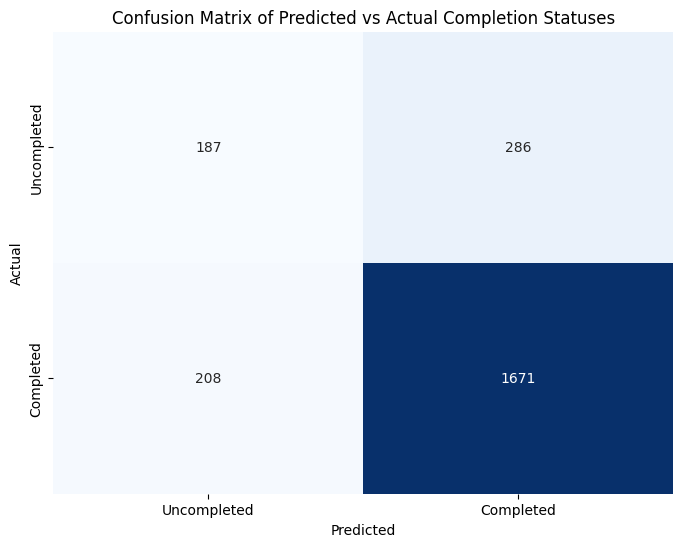

In [ ]:
# Create the pipeline using SMOTE oversampling
svc_final = Pipeline([
    ("smote", SMOTE(random_state=0)),
    ("svc", SVC(kernel="poly", C=1, random_state=0))
])

# Fit the pipeline for the training data
svc_final.fit(X_train_scaled, y_train)

# Generate model evaluation results
svc_final_result = model_eval_report(svc_final, X_train_scaled, y_train, X_test_scaled, y_test)
conf_mtx_heatmap(svc_final_result)

#### Logistic Regression

Logistic regression was utilised to also predict student completion statuses. Three solvers and regularisation (C) values were tested.

In [ ]:
# Set solvers and C-values to test
solvers = ["newton-cg", "lbfgs", "liblinear"]

# Loop through each solver and C-value
for solver in solvers:
    for c in c_vals:
        # Create the pipeline using SMOTE oversampling
        log_reg_pipe = Pipeline([
            ("smote", SMOTE(random_state=0)),
            ("log_reg", LogisticRegression(solver=solver, C=c, random_state=0))
        ])

        # Generate model evaluation results
        print(f"\nSolver: {solver}, C-value: {c}")
        model_eval_report(log_reg_pipe, X_train_scaled, y_train, X_test_scaled, y_test)


Solver: newton-cg, C-value: 0.1
Cross-validation results:  [0.75026567 0.76036132 0.74906964 0.74534822 0.73577884]
Mean cross-validation result:  0.7481647392884039

Classification report:
               precision    recall  f1-score   support

           1       0.41      0.60      0.48       473
           2       0.88      0.78      0.83      1879

    accuracy                           0.74      2352
   macro avg       0.65      0.69      0.66      2352
weighted avg       0.79      0.74      0.76      2352


Solver: newton-cg, C-value: 1
Cross-validation results:  [0.75026567 0.76036132 0.74800638 0.74641148 0.73684211]
Mean cross-validation result:  0.7483773921326357

Classification report:
               precision    recall  f1-score   support

           1       0.41      0.60      0.48       473
           2       0.88      0.78      0.83      1879

    accuracy                           0.74      2352
   macro avg       0.65      0.69      0.66      2352
weighted avg       

Very little difference was noted between the solvers and regularisation strengths, though solver newton-cg with 1 as the regularisation strength was chosen from these. The final logistic regression model was constructed using the newton-cg solver and a regularisation strength of 1.  

Cross-validation results:  [0.75026567 0.76036132 0.74800638 0.74641148 0.73684211]
Mean cross-validation result:  0.7483773921326357

Classification report:
               precision    recall  f1-score   support

           1       0.41      0.60      0.48       473
           2       0.88      0.78      0.83      1879

    accuracy                           0.74      2352
   macro avg       0.65      0.69      0.66      2352
weighted avg       0.79      0.74      0.76      2352



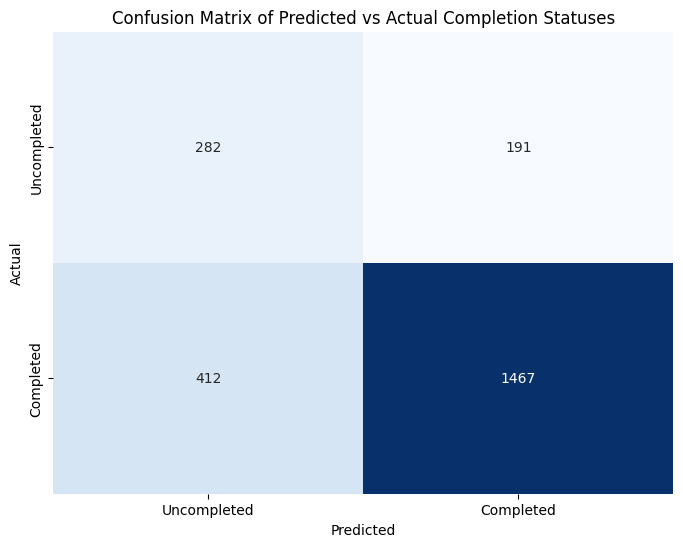

In [ ]:
# Create a pipeline with SMOTE
log_reg_final = Pipeline([
    ("smote", SMOTE(random_state=0)),
    ("log_reg", LogisticRegression(solver="newton-cg", C=1, random_state=0))
])

# Fit the pipeline for the training data
log_reg_final.fit(X_train_scaled, y_train)

# Generate model evaluation results
log_reg_final_result = model_eval_report(log_reg_final, X_train_scaled, y_train, X_test_scaled, y_test)
conf_mtx_heatmap(log_reg_final_result)

### Identifying Student Groups via Clustering

#### K-means Clustering

A K-means clustering model was implemented to identify distinct student groups. Since K-means is a clustering method, there's no need for a train-test split. Instead, 'X_scaled', using the entire dataset, was created using the same scaling method.

In [ ]:
X_scaled = X.copy()

X_scaled[["Attendance%", "Comments of Concern"]] = scaler.transform(
    X[["Attendance%", "Comments of Concern"]]
)

To determine the ideal number of clusters, the elbow method was employed. 5 was determined as the optimal number of clusters from this.

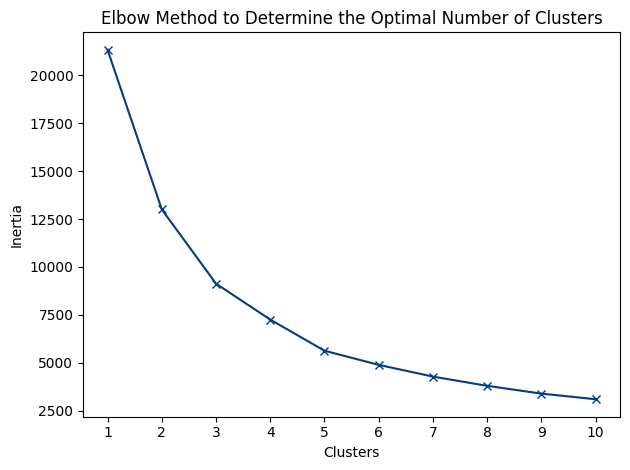

In [ ]:
# Set up array for storing inertias and 10 clusters to test
inertias = []
clusters = range(1, 11)

# Loop through each number of clusters
for n in clusters:
    
    # Test k-means for each number of clusers
    k_means = KMeans(n_clusters=n)
    k_means.fit(X_scaled)

    # Append results to inertias
    inertias.append(k_means.inertia_)

# Generate line plot of results
plt.plot(clusters, inertias, marker="x", color="#003C86")

# Create chart title
plt.title("Elbow Method to Determine the Optimal Number of Clusters")

# Set x-ticks
plt.xticks(clusters)

# Label axes
plt.xlabel("Clusters")
plt.ylabel("Inertia")

# Display plot
plt.tight_layout()
plt.show()

The final k-means cluster model was created. This was initially visualised using a 3D scatter plot, however this was not very interpretable. 

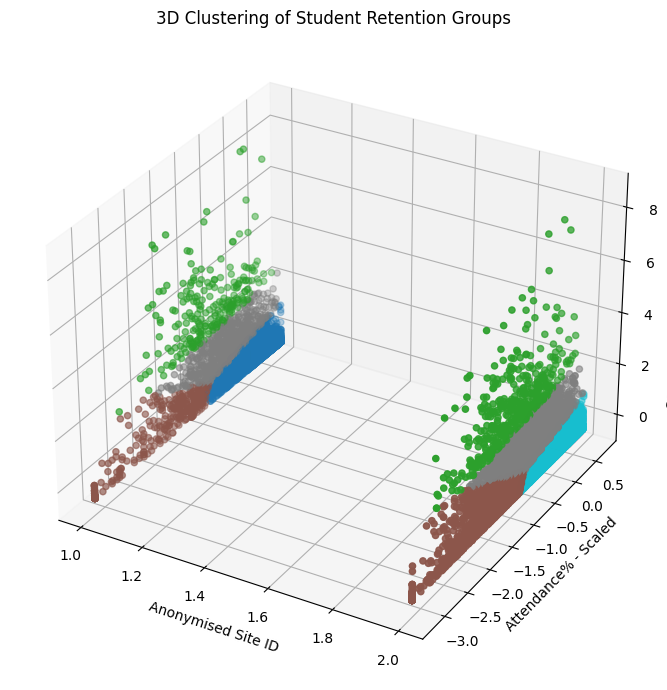

In [ ]:
# Fit the KMeans model
k_means = KMeans(n_clusters=5, random_state=0).fit(X_scaled)

# Get the cluster labels for each data point
labels = k_means.labels_

# Generate the 3D scatter plot
fig = plt.figure(figsize=(7, 7))
axs = fig.add_subplot(111, projection="3d")
axs.scatter(
    X_scaled["Anonymised Site ID"],
    X_scaled["Attendance%"],
    X_scaled["Comments of Concern"],
    c=labels,
    cmap="tab10",
)

# Label axes
axs.set_xlabel("Anonymised Site ID")
axs.set_ylabel("Attendance% - Scaled")
axs.set_zlabel("Comments of Concern - Scaled")

# Create chart title
axs.set_title("3D Clustering of Student Retention Groups")

# Display plot
plt.tight_layout()
plt.show()

Instead, 2D scatter plots were generated for each site, providing clearer interpretation. The plots revealed five distinct student groups.

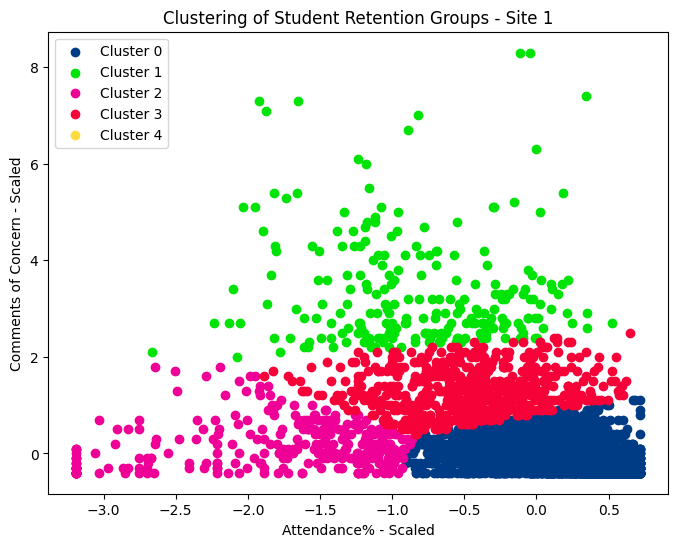

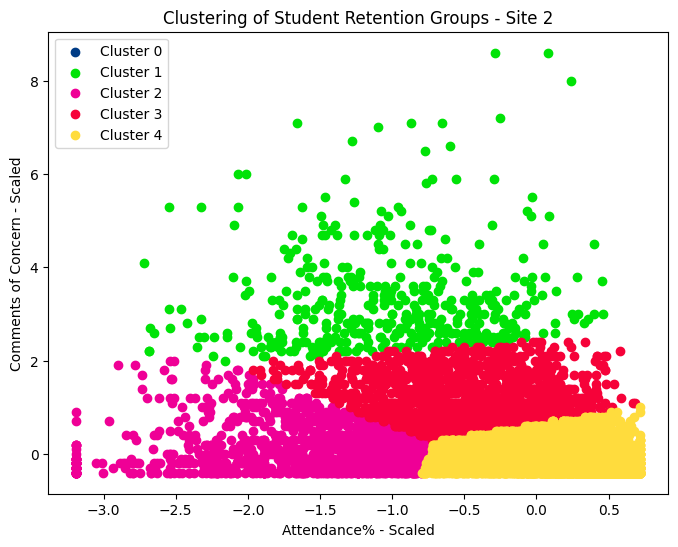

In [ ]:
# Define custom colors for clusters
cluster_colors = ["#003C86", "#00E307", "#EF0096", "#F60239", "#FFDC3D"]

# Loop over each site
unique_sites = X_scaled['Anonymised Site ID'].unique()

for site in unique_sites:
    # Filter by the current site
    site_data = X_scaled[X_scaled['Anonymised Site ID'] == site]
    site_labels = labels[X_scaled['Anonymised Site ID'] == site]

    # Generate scatter plot for each site
    plt.figure(figsize=(8, 6))
    for cluster_label in np.unique(labels):
        cluster_data = site_data[site_labels == cluster_label]
        plt.scatter(
            cluster_data["Attendance%"],
            cluster_data["Comments of Concern"],
            color=cluster_colors[cluster_label],
            label=f"Cluster {cluster_label}",
        )

    # Label axes
    plt.xlabel("Attendance% - Scaled")
    plt.ylabel("Comments of Concern - Scaled")

    # Create chart titles
    plt.title(f"Clustering of Student Retention Groups - Site {site}")

    # Add legend
    plt.legend()

    # Display plots
    plt.show()

### Estimating 'Comments of Concern' based on 'Attendance%'

#### Linear Regression

A linear regression model was created to estimate the number of 'Comments of Concern' using 'Attendance%'. These attributes were assigned to X and y respectively. 

In [ ]:
# Set X and y features and target variables respectively
X = stud_ret_df["Attendance%"].values.reshape(
    -1, 1
)  # Reshape 1D to 2D to work with linear regression
y = stud_ret_df["Comments of Concern"]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

The linear regression model was evaluated using cross validation and repeated k-fold. The performance of the model was rather poor.

Intercept: 19.966698434456436
Coefficient: -0.16069660944994513

Cross-validation R2: [0.10997237 0.09690809 0.12088992 0.08544401 0.131708   0.09973364
 0.10986309 0.131638   0.11136975 0.09419197 0.11403141 0.10170729
 0.11811599 0.08291723 0.13250405 0.11147782 0.11540517 0.10828529
 0.0932905  0.12160604 0.09321851 0.12701677 0.13158275 0.1115895
 0.08405928]
Mean cross validation R2: 0.10954105766961483

Cross-validation mean squared error: [ -92.40438842  -84.1848763   -81.15901937  -86.94415396  -83.6738768
  -83.32571801  -77.70113985  -83.70202385  -92.01324643  -91.52485718
  -87.1911184   -82.27278122  -92.43140121  -91.48264777  -74.90575926
  -86.03228754  -87.77749633  -78.95149607  -89.68642837  -85.63014363
 -100.05028424  -83.95422006  -81.24320799  -75.64154477  -87.41758791]
Mean cross validation mean squared error: -85.65206819740389

Cross-validation root mean squared error: [ -9.61272014  -9.17523168  -9.00883008  -9.32438491  -9.14734261
  -9.12829217  -8.814825 

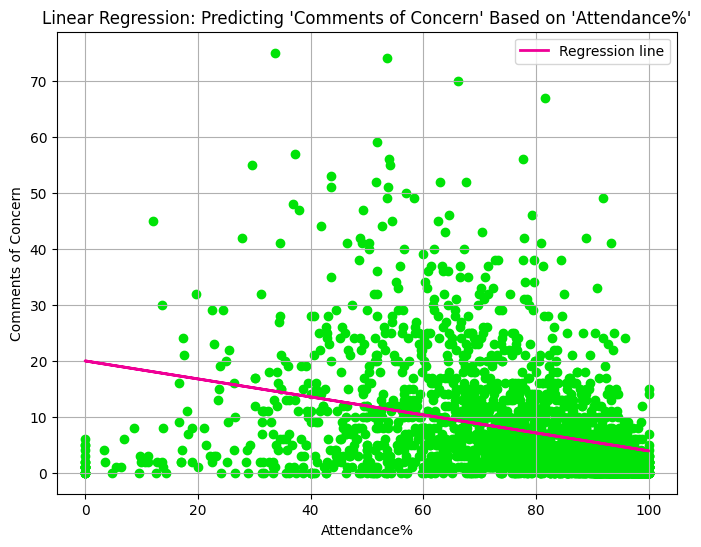

In [ ]:
# Initialise the Linear Regression model
lin_reg_model = LinearRegression()

# Fit the model for training data
lin_reg_model.fit(X_train, y_train)

# Print the intercept and coefficients
print("Intercept:", lin_reg_model.intercept_)
print("Coefficient:", lin_reg_model.coef_[0])

# Dictionary of regression scoring metrics
lin_reg_metrics = {
    "r2": "R2",
    "neg_mean_squared_error": "mean squared error",
    "neg_root_mean_squared_error": "root mean squared error",
    "neg_mean_absolute_error": "mean absolute error",
}

# Setup repeated k-fold cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

# Loop through each metric and print evaluation results
for key, value in lin_reg_metrics.items():
    results = cross_val_score(
        lin_reg_model,
        X_train,
        y_train,
        cv=rkf,
        scoring=key,
    )

    print(f"\nCross-validation {value}:", results)
    print(f"Mean cross validation {value}:", results.mean())

# Predict 'Comments of Concern' for the test data
y_pred = lin_reg_model.predict(X_test)

# Create the regression line
regression_line = lin_reg_model.intercept_ + lin_reg_model.coef_[0] * X_test

# Generate the scatter plot with the regression line
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color="#00E307")
plt.plot(
    X_test,
    regression_line,
    color="#EF0096",
    linewidth=2,
    label="Regression line",
)

# Label axes
plt.xlabel("Attendance%")
plt.ylabel("Comments of Concern")

# Create chart title
plt.title(
    "Linear Regression: Predicting 'Comments of Concern' Based on 'Attendance%'"
)

# Add legend
plt.legend()

# Show gridlines
plt.grid(True)

# Display plot
plt.show()